In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import pickle
import seaborn as sns

from sklearn.metrics import f1_score,precision_score

from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

In [2]:
league=[]
teams=[]
home_games_by_team=[]
away_games_by_team=[]
all_games_by_team={}
league_table_by_matchday={}

In [3]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

In [4]:
league=pd.read_csv("Italy/T2/I20.csv")
league = league.loc[:,"Date":"AR"]
try:
        league["Date"]=pd.to_datetime(league["Date"],format="%d/%m/%Y")
except ValueError:
        league["Date"]=pd.to_datetime(league["Date"],format="%d/%m/%y")
drop_cols=["HTR","HF","AF","HY","AY","HR","AR","HC","AC","HTHG","HTAG","Referee","Time"]
for col in drop_cols:
    try:
        league.drop(columns=[col],inplace=True)
    except KeyError:
        continue
teams= league["HomeTeam"].unique()
home_games_by_team=league.groupby("HomeTeam")
away_games_by_team=league.groupby("AwayTeam")
all_games_by_team={}
league_table_by_matchday={}

In [5]:
def teamAllGames():
    
    h_rename={"AwayTeam":"Opponenet","HomeTeam":"Team Name","FTHG":"Goals","HS":"Shots",
              "HST":"Shots On Target","HC":"Corners","FTAG":"Goals Conceded","AS":"Shots Conceded",
              "AST":"Shots On Target Conceded","AC":"Corners Conceded"}
    a_rename={"HomeTeam":"Opponenet","AwayTeam":"Team Name","FTHG":"Goals Conceded","HS":"Shots Conceded",
              "HST":"Shots On Target Conceded","HC":"Corners Conceded","FTAG":"Goals","AS":"Shots",
              "AST":"Shots On Target","AC":"Corners"}
    for team in teams:
        home_games=home_games_by_team.get_group(team).copy()
        away_games=away_games_by_team.get_group(team).copy()

        home_games.rename(columns=h_rename,inplace=True)
        away_games.rename(columns=a_rename,inplace=True)
        home_games["Side"]="Home"
        away_games["Side"]="Away"
        
        all_games=pd.concat([home_games,away_games])
        all_games["FTR"]=all_games.apply(lambda x:"Win" if (x["Goals"]>x["Goals Conceded"]) else "Draw" if (x["Goals"]==x["Goals Conceded"]) else "Loss",axis=1)
        all_games=all_games.join(pd.get_dummies(all_games["FTR"]))
        if "Win" not in all_games.columns:
            all_games["Win"]=0
        if "Draw" not in all_games.columns:
            all_games["Draw"]=0
        if "Loss" not in all_games.columns:
            all_games["Loss"]=0
        all_games.drop(columns=["FTR","Loss"],inplace=True)
        all_games_by_team[team]=all_games.sort_values(["Date"],ascending=True)

In [6]:
def teamAllGamesPerformance(row):
    if row["Side"]=="Home":
        row["Off Performance"]=league.loc[row.name,:]["Home Off Performance"]
        row["Def Performance"]=league.loc[row.name,:]["Away Off Performance"]
        
        row["Side Off Performance"]=league.loc[row.name,:]["Side Home Off Performance"]
        row["Side Def Performance"]=league.loc[row.name,:]["Side Away Off Performance"]
        
        row["Form Off Performance"]=league.loc[row.name,:]["Form Home Off Performance"]
        row["Form Def Performance"]=league.loc[row.name,:]["Form Away Off Performance"]
        
    
    else:
        row["Off Performance"]=league.loc[row.name,:]["Away Off Performance"]
        row["Def Performance"]=league.loc[row.name,:]["Home Off Performance"]
        
        row["Side Off Performance"]=league.loc[row.name,:]["Side Away Off Performance"]
        row["Side Def Performance"]=league.loc[row.name,:]["Side Home Off Performance"]
        
        row["Form Off Performance"]=league.loc[row.name,:]["Form Away Off Performance"]
        row["Form Def Performance"]=league.loc[row.name,:]["Form Home Off Performance"]
    return row

def applyDiff():
    for key,dframe in all_games_by_team.items():
        all_games_by_team[key]=dframe.apply(lambda x:teamAllGamesPerformance(x),axis=1)

In [7]:
def getPerformanceAvgs(row):
    hteam=all_games_by_team[row["HomeTeam"]]
    ateam=all_games_by_team[row["AwayTeam"]]
    row["Home Off Performance"]=hteam.loc[hteam["Date"]<row["Date"],"Off Performance"].tail(5).mean()
    row["Away Off Performance"]=ateam.loc[ateam["Date"]<row["Date"],"Off Performance"].tail(5).mean()
    
    row["Side Home Off Performance"]=hteam.loc[(hteam["Date"]<row["Date"]) &(hteam["Side"]=="Home"),"Side Off Performance"].tail(5).mean()
    row["Side Away Off Performance"]=ateam.loc[(ateam["Date"]<row["Date"]) &(ateam["Side"]=="Away"),"Side Off Performance"].tail(5).mean()
    
    row["Form Home Off Performance"]=hteam.loc[hteam["Date"]<row["Date"],"Form Off Performance"].tail(5).mean()
    row["Form Away Off Performance"]=ateam.loc[ateam["Date"]<row["Date"],"Form Off Performance"].tail(5).mean()
    
    row["Home Def Performance"]=hteam.loc[hteam["Date"]<row["Date"],"Def Performance"].tail(5).mean()
    row["Away Def Performance"]=ateam.loc[ateam["Date"]<row["Date"],"Def Performance"].tail(5).mean()
    
    row["Side Home Def Performance"]=hteam.loc[(hteam["Date"]<row["Date"]) &(hteam["Side"]=="Home"),"Side Def Performance"].tail(5).mean()
    row["Side Away Def Performance"]=ateam.loc[(ateam["Date"]<row["Date"]) &(ateam["Side"]=="Away"),"Side Def Performance"].tail(5).mean()
    
    row["Form Home Def Performance"]=hteam.loc[hteam["Date"]<row["Date"],"Form Def Performance"].tail(5).mean()
    row["Form Away Def Performance"]=ateam.loc[ateam["Date"]<row["Date"],"Form Def Performance"].tail(5).mean()
    return row

In [8]:
def HomeAwayStats(lr,team_stats,stats=[]):
    for stat in stats:
        lr[stat]= team_stats[stat].sum()
        lr["Home "+stat]= team_stats.loc[team_stats["Side"]=="Home",stat].sum()
        lr["Away "+stat]= team_stats.loc[team_stats["Side"]=="Away",stat].sum()
    lr["Home GP"]=team_stats.loc[team_stats["Side"]=="Home","Goals"].count()
    lr["Away GP"]=team_stats.loc[team_stats["Side"]=="Away","Goals"].count()
    
def formStats(lr,team_stats,stats=[]):
    for stat in stats:
        lr["Form "+stat]= team_stats[stat].sum()
    

def getLeagueTable():
    side_stats=["Goals","Goals Conceded","Shots","Shots Conceded",
                "Shots On Target","Shots On Target Conceded"]
    
    for date in league["Date"].unique():
        team_dict=[]
        for team in teams:
            team_stats=all_games_by_team[team].copy()
            team_stats = team_stats.loc[team_stats["Date"]<date,:]
            
            league_record={"Team":team,"Wins":team_stats["Win"].sum(),"Draws":team_stats["Draw"].sum()}
            league_record["Losses"]=team_stats["Team Name"].count()-league_record["Wins"]-league_record["Draws"]
            league_record["Points"]=league_record["Wins"]*3 +league_record["Draws"]
            league_record["GP"]=len(team_stats)
            HomeAwayStats(league_record,team_stats,side_stats)
            league_record["Goal Difference"]=league_record["Goals"]-league_record["Goals Conceded"]
            
             
            form_stats=team_stats.tail(5)
            league_record["Form Wins"]=form_stats["Win"].sum()
            league_record["Form Draws"]=form_stats["Draw"].sum()
            league_record["Form Losses"]=form_stats["Team Name"].count()-league_record["Form Wins"]-league_record["Form Draws"]
            league_record["Form Points"]=league_record["Form Wins"]*3 +league_record["Form Draws"]
            league_record["Form GP"]=len(form_stats)
            formStats(league_record,form_stats,side_stats)
            league_record["Form Goal Difference"]=league_record["Form Goals"]-league_record["Form Goals Conceded"]
            
            team_dict.append(league_record)
        res=pd.DataFrame(team_dict).sort_values("Points",ascending=False).reset_index(drop=True)
        res["Position"]=res.index+1
        league_table_by_matchday[pd.Timestamp(date)]=res
        
   

In [9]:
def versusStats(row):
    home_relevant_stats=["Team","Wins","Draws","Losses","Points",
                        "Goal Difference","Position","XG","XG Conceded","Home XG","Home XG Conceded",
                        "Form XG","Form XG Conceded"]
    away_relevant_stats=["Team","Wins","Draws","Losses","Points",
                         "Goal Difference","Position","XG","XG Conceded","Away XG","Away XG Conceded",
                         "Form XG","Form XG Conceded"]
    home=getTeamLeagueCombined(row["HomeTeam"],row["Date"]).loc[:,home_relevant_stats]
    away=getTeamLeagueCombined(row["AwayTeam"],row["Date"]).loc[:,away_relevant_stats]
    away_rename ={"Team":"Away Team","Wins":"Away Wins","Draws":"Away Draws","Losses":"Away Losses",
                  "Points":"Away Points","Goals":"(A)Away Goals","Goals Conceded":"(A) Goals Conceded",
                  "Shots Conceded":"(A)Away Shots Conceded",
                   "Shots On Target":"(A)Away Shots On Target",
                   "Shots On Target Conceded":"(A)Away Shots On Target Conceded",
                  "Goal Difference":"Away Goal Difference","Points":"Away Points","Position":"Away Position",
                 "Away XG":"(A) Away XG","Away XG Conceded":"(A) Away XG Conceded","XG":"Away XG","XG Conceded":"Away XG Conceded",
                 "Form XG":"Away Form XG","Form XG Conceded":"Away Form XG Conceded"}
    
    
    away.rename(columns=away_rename,inplace=True)
    
    home["Home Expected"]=(home["XG"]+away["Away XG Conceded"])/2
    home["Away Expected"]=(home["XG Conceded"]+away["Away XG"])/2
    
    home["Side Home Expected"]=(home["Home XG"]+away["(A) Away XG Conceded"])/2
    home["Side Away Expected"]=(home["Home XG Conceded"]+away["(A) Away XG"])/2
    
    home["Form Home Expected"]=(home["Form XG"]+away["Away Form XG Conceded"])/2
    home["Form Away Expected"]=(home["Form XG Conceded"]+away["Away Form XG"])/2
    
    vs_stats=pd.concat([home,away],axis=1).iloc[0]
    '''if vs_stats.name == row.name:
        vs_stats=vs_stats.rename(1000)'''
    #print(vs_stats,row)
    row = pd.concat([row,vs_stats])
    return row

In [10]:
def getExpected(league_stats,prefs):
    drop_cols=["Goals","Home Goals","Away Goals",
              "Goals Conceded","Home Goals Conceded","Away Goals Conceded",
              "Shots","Home Shots","Away Shots",
              "Shots Conceded","Home Shots Conceded","Away Shots Conceded",
              "Shots On Target","Home Shots On Target","Away Shots On Target",
              "Shots On Target Conceded","Home Shots On Target Conceded","Away Shots On Target Conceded"]
    for pref in prefs:
        league_stats["Accuracy"]=league_stats[pref+"Shots On Target"]/league_stats[pref+"Shots"]
        league_stats["Goals PG"]=league_stats[pref+"Goals"]/league_stats[pref+"GP"]
        league_stats["Shots On Target PG"]=league_stats[pref+"Shots On Target"]/league_stats[pref+"GP"]
        league_stats["Shots PG"]=league_stats[pref+"Shots"]/league_stats[pref+"GP"]
        league_stats["Effeciency"]=league_stats["Goals PG"]/league_stats["Shots On Target PG"]
        league_stats[pref+"XG"]=league_stats["Shots PG"]*league_stats["Accuracy"]*league_stats["Effeciency"]
        
        league_stats["Accuracy OP"]=league_stats[pref+"Shots On Target Conceded"]/league_stats[pref+"Shots Conceded"]
        league_stats["Goals PG OP"]=league_stats[pref+"Goals Conceded"]/league_stats[pref+"GP"]
        league_stats["Shots On Target PG OP"]=league_stats[pref+"Shots On Target Conceded"]/league_stats[pref+"GP"]
        league_stats["Shots PG OP"]=league_stats[pref+"Shots Conceded"]/league_stats[pref+"GP"]
        league_stats["Effeciency OP"]=league_stats["Goals PG OP"]/league_stats["Shots On Target PG OP"]
        league_stats[pref+"XG Conceded"]=league_stats["Shots PG OP"]*league_stats["Accuracy OP"]*league_stats["Effeciency OP"]
        league_stats.drop(columns=["Accuracy OP","Goals PG OP","Shots On Target PG OP","Shots PG OP","Effeciency OP"],inplace=True)
        league_stats.drop(columns=["Accuracy","Goals PG","Shots On Target PG","Shots PG","Effeciency"],inplace=True)
    league_stats.drop(columns=drop_cols,inplace=True)
#def getTeamLeagueCombined(Team,date=pd.league.loc[len(league)-1,"Date"]):
def getTeamLeagueCombined(Team,date):
    standard_columns=["Wins","Draws","Losses",
                     "Goal Difference","Points","Position"]
    scaler=MinMaxScaler()
    table=league_table_by_matchday[date]
    table[standard_columns]=scaler.fit_transform(table[standard_columns])
    league_stats=table.loc[table["Team"]==Team,:].copy()
    side_stat=["","Home ","Away ","Form "]
    getExpected(league_stats,side_stat)
    #return league_stats
    return league_stats.reset_index()

In [11]:
def resPercentage(row):
    # result options H,A,D
    """vals=["Home Wins Ratio","Away Wins Ratio","Draws Ratio","Home Goals Avg",
          "Away Goals Avg"]"""
    sub_league=league.loc[league["Date"]<row["Date"],:].copy()
    games = sub_league.shape[0]
    """if games==0:
        for val in vals:
            row[val]=0
        return row"""
    #row["League Home Wins Ratio"]=(sub_league.loc[sub_league["FTR"]=="H","FTR"].count()/games) if games!=0 else 0
    #row["League Away Wins Ratio"]=sub_league.loc[sub_league["FTR"]=="A","FTR"].count()/games if games!=0 else 0
    #row["League Draws Ratio"]=sub_league.loc[sub_league["FTR"]=="D","FTR"].count()/games if games!=0 else 0
    row["League Home Goals Avg"]=sub_league.loc[:,"FTHG"].sum()/games if games!=0 else 0
    row["League Away Goals Avg"]=sub_league.loc[:,"FTAG"].sum()/games if games!=0 else 0
    
    row.fillna(0,inplace=True)
    return row

### **Fixture difficulty**   
This is how I want to approcah the fact that all match fxtures are not the same  e.g averaging 1 goal per game vs the bottom 3 defensive teams is not the same as averaging the same against the top 3 defenses. There are 2 main angles i want to approach this from   
1. League Position
2. Match performance   
#### League Position
This will be based on the average position of your opponents
#### Match performance
This will invlve geting expected statistics from averages then then comparing them to actual results e.g the best offensive team may be averging 2 goals per game and is playing the worst defensive team with 3 goals conceded per game. The proposed stat comparison should be able to show the top team has underperformed if it scores just 2 goals even if thats it's everage since the competition is weaker than what they have faced previously

In [12]:
def positionEffect(row,effects,presets):
    vals=["Position Leader Wins","Position Leader Loses","Position Leader Draws"]
    
    games=league.loc[league["Date"]<row["Date"],["Date","HomeTeam","AwayTeam","FTR"]]
    gp=games["FTR"].count()
    if gp==0:
        for val in vals:
            presets["Date"]=row["Date"]
            row[val]=0
        effects[str(row["Date"])]=row[vals]
        return row
    
    if str(row["Date"]) in effects:
        row= pd.concat([row,effects[str(row["Date"])]])
        return row
    
    row_conditon=(league["Date"]>= presets["Date"]) & (league["Date"]<row["Date"])
    games=league.loc[row_conditon,:]
    
    
    position_leader_wins=presets["position_leader_wins"]
    position_leader_losses= presets["position_leader_losses"]
    position_leader_draws= presets["position_leader_draws"]
    
    for index,game in games.iterrows():
        home_pos=game["Position"]
        away_pos= game["Away Position"]
        #the positions are already standardized so 1 would be 0 and 20 would be 1 so we reverse the if conditions
        #check if home team is the highr position team and tally the result
        if home_pos< away_pos:
            if game["FTR"]=="H":
                position_leader_wins+=1
            elif game["FTR"]=="A":
                position_leader_losses+=1
            else:
                position_leader_draws+=1
        elif away_pos<home_pos:
            if game["FTR"]=="A":
                position_leader_wins+=1
            elif game["FTR"]=="H":
                position_leader_losses+=1
            else:
                position_leader_draws+=1
    presets["position_leader_wins"]=position_leader_wins
    presets["position_leader_losses"]=position_leader_losses
    presets["position_leader_draws"]=position_leader_draws
    presets["Date"]=row["Date"]
    
    row["Position Leader Wins"]=position_leader_wins/gp
    row["Position Leader Loses"]=position_leader_losses/gp
    row["Position Leader Draws"]=position_leader_draws/gp
    effects[str(row["Date"])]=row[vals]
    #print(row.name)
    #return pd.DataFrame.from_dict(res,orient="index").T
    return row

In [13]:
def getPerformance(row):  
    row["Home Off Performance"]=row["FTHG"]/row["Home Expected"] if row["Home Expected"]>0 else row["FTHG"]
    row["Away Off Performance"]=row["FTAG"]/row["Away Expected"] if row["Away Expected"]>0 else row["FTAG"]
    
    row["Side Home Off Performance"]=row["FTHG"]/row["Side Home Expected"] if row["Side Home Expected"]>0 else row["FTHG"]
    row["Side Away Off Performance"]=row["FTAG"]/row["Side Away Expected"] if row["Side Away Expected"]>0 else row["FTAG"]
    
    row["Form Home Off Performance"]=row["FTHG"]/row["Form Home Expected"] if row["Form Home Expected"]>0 else row["FTHG"]
    row["Form Away Off Performance"]=row["FTAG"]/row["Form Away Expected"] if row["Form Away Expected"]>0 else row["FTAG"]
    #all_games_by_team[row["Home Team"]].loc[row.name,:]
    
    return row

In [14]:
def tierCSV():
    all_seasons_path=cons_path
    new_files=os.listdir(out_path)
    new_files=[f for f in new_files if os.path.isfile(out_path+"/"+f)]
    dataframes=[]
    for file in new_files:
        dataframes.append(pd.read_csv(out_path+"/"+file))
    all_seasons=pd.concat(dataframes).reset_index(drop=True).dropna(axis=1)
    
    all_seasons.to_csv(all_seasons_path,index=False)
    
    final_files=os.listdir("Allseasons")
    final_files=[f for f in final_files if os.path.isfile("Allseasons/"+f)]
    all_frames=[]
    for file in final_files:
        all_frames.append(pd.read_csv("Allseasons/"+file))
    all_football=pd.concat(all_frames).reset_index(drop=True).dropna(axis=1)
    
    all_football.to_csv("AllLeagues.csv",index=False)
    return all_seasons

In [15]:
def getGP(row):
    lt=league_table_by_matchday[row["Date"]]
    row["Home GP"]=lt.loc[lt["Team"]==row["HomeTeam"],"GP"].values[0]
    row["Away GP"]=lt.loc[lt["Team"]==row["AwayTeam"],"GP"].values[0]
    return row

In [16]:
teams= league["HomeTeam"].unique()
home_games_by_team=league.groupby("HomeTeam")
away_games_by_team=league.groupby("AwayTeam")
all_games_by_team={}
league_table_by_matchday={}

teamAllGames()
getLeagueTable()
league=league.apply(lambda c:versusStats(c),axis=1)



presets = {"position_leader_wins":0,"position_leader_losses":0,"position_leader_draws":0}
effects={}
        #league=league.apply(lambda x:positionEffect(x,effects,presets),axis=1)

league=league.apply(lambda x:resPercentage(x),axis=1)
drop_cols=["XG","XG Conceded","Home XG","Home XG Conceded","Form XG","Form XG Conceded",
        "Away XG","Away XG Conceded","(A) Away XG","(A) Away XG Conceded","Away Form XG","Away Form XG Conceded","HS","HST","AS","AST","Team","Away Team"]
league.drop(drop_cols,axis=1,inplace=True)
league=league.apply(lambda x:getPerformance(x),axis=1)
applyDiff()
league=league.apply(lambda row:getPerformanceAvgs(row),axis=1)
league= league.apply(lambda row:getGP(row),axis=1)
league=league.loc[(league["Home GP"]>6) & (league["Away GP"]>6),:]
league.drop(columns=["Home GP","Away GP"],inplace=True)
#league.to_csv(out_path+"/"+file,index=False)
league

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Wins,Draws,Losses,Points,Goal Difference,Position,Home Expected,Away Expected,Side Home Expected,Side Away Expected,Form Home Expected,Form Away Expected,Away Wins,Away Draws,Away Losses,Away Points,Away Goal Difference,Away Position,League Home Goals Avg,League Away Goals Avg,Home Off Performance,Away Off Performance,Side Home Off Performance,Side Away Off Performance,Form Home Off Performance,Form Away Off Performance,Home Def Performance,Away Def Performance,Side Home Def Performance,Side Away Def Performance,Form Home Def Performance,Form Away Def Performance
70,2019-10-18,Cittadella,Cosenza,1,3,A,1.000000,0.000,0.600000,0.727273,0.500000,0.315789,1.071429,0.928571,1.000000,0.833333,1.3,0.6,0.000000,1.000,0.600000,0.000000,0.375000,0.789474,1.285714,1.171429,1.134231,0.875152,0.888889,0.666667,1.098333,0.894199,0.220000,1.088889,1.222222,0.500000,0.220000,1.070707
71,2019-10-19,Juve Stabia,Pordenone,4,2,H,0.000000,0.250,1.000000,0.000000,0.000000,1.000000,0.857143,1.714286,1.333333,2.000000,0.7,1.5,0.666667,0.500,0.400000,0.636364,0.750000,0.421053,1.281690,1.197183,0.736364,0.946374,0.333333,1.111111,0.871429,1.021587,1.132843,0.865934,1.944444,1.814815,1.134524,0.865934
72,2019-10-19,Pescara,Spezia,1,2,A,0.666667,0.250,0.600000,0.545455,0.500000,0.578947,1.714286,1.428571,1.500000,1.500000,1.7,1.1,0.000000,0.250,1.000000,0.000000,0.250000,0.842105,1.281690,1.197183,0.880952,0.787692,1.500000,1.000000,0.871429,0.787692,1.041905,1.817460,1.555556,0.888889,1.041905,1.798413
73,2019-10-19,Venezia,Salernitana,1,0,H,0.333333,0.750,0.400000,0.454545,0.562500,0.684211,1.000000,1.214286,0.666667,1.666667,1.1,1.1,1.000000,0.500,0.200000,0.909091,0.750000,0.052632,1.281690,1.197183,1.353247,0.906316,0.777778,1.666667,1.335065,0.933846,1.000000,1.287388,1.277778,1.333333,1.019048,1.269206
74,2019-10-19,Virtus Entella,Trapani,1,1,D,0.666667,0.500,0.400000,0.636364,0.500000,0.368421,1.214286,0.928571,1.500000,1.166667,1.1,1.2,0.000000,0.250,1.000000,0.000000,0.250000,0.947368,1.281690,1.197183,0.900000,1.030065,0.500000,1.400000,0.885714,1.031746,1.753247,1.184056,1.333333,1.777778,1.653247,1.319121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2020-07-31,Livorno,Empoli,0,2,A,0.000000,0.000,1.000000,0.000000,0.000000,1.000000,1.054054,1.486486,1.222222,1.638889,1.5,2.1,0.400000,0.750,0.363636,0.483871,0.438356,0.473684,1.397297,1.094595,0.683612,1.568743,0.325322,1.401977,0.696970,1.368900,1.509677,2.031752,1.424006,0.635849,1.534655,2.519841
376,2020-07-31,Salernitana,Spezia,1,2,A,0.450000,0.500,0.409091,0.500000,0.534247,0.421053,1.229730,1.351351,1.527778,1.194444,1.2,1.6,0.550000,0.500,0.318182,0.596774,0.657534,0.105263,1.397297,1.094595,1.562504,0.877469,1.644871,1.020325,1.416792,0.864469,1.621340,0.372063,2.133391,0.904732,1.413102,0.309524
377,2020-07-31,Trapani,Crotone,2,0,H,0.250000,0.875,0.454545,0.354839,0.287671,0.894737,1.135135,1.662162,1.361111,1.388889,1.1,1.6,0.750000,0.250,0.227273,0.758065,0.821918,0.052632,1.397297,1.094595,1.446938,1.477610,1.219752,1.633852,1.191941,1.401539,0.699870,0.542447,0.218679,0.632982,0.909091,0.709402
378,2020-07-31,Venezia,Perugia,3,1,H,0.300000,1.000,0.363636,0.419355,0.410959,0.631579,1.081081,1.027027,1.166667,1.138889,1.0,0.9,0.350000,0.375,0.545455,0.387097,0.356164,0.736842,1.397297,1.094595,0.777484,0.997438,0.767439,1.235154,0.737179,1.032634,0.473600,0.974168,1.151493,0.872884,0.598485,1.037851


### The correlation matrix can be used for feature selection/ importance . It can also be used to identify correlation of features ###

In [17]:
correlation_matrix = league.corr()

/tmp/ipykernel_20154/4280344796.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = league.corr()


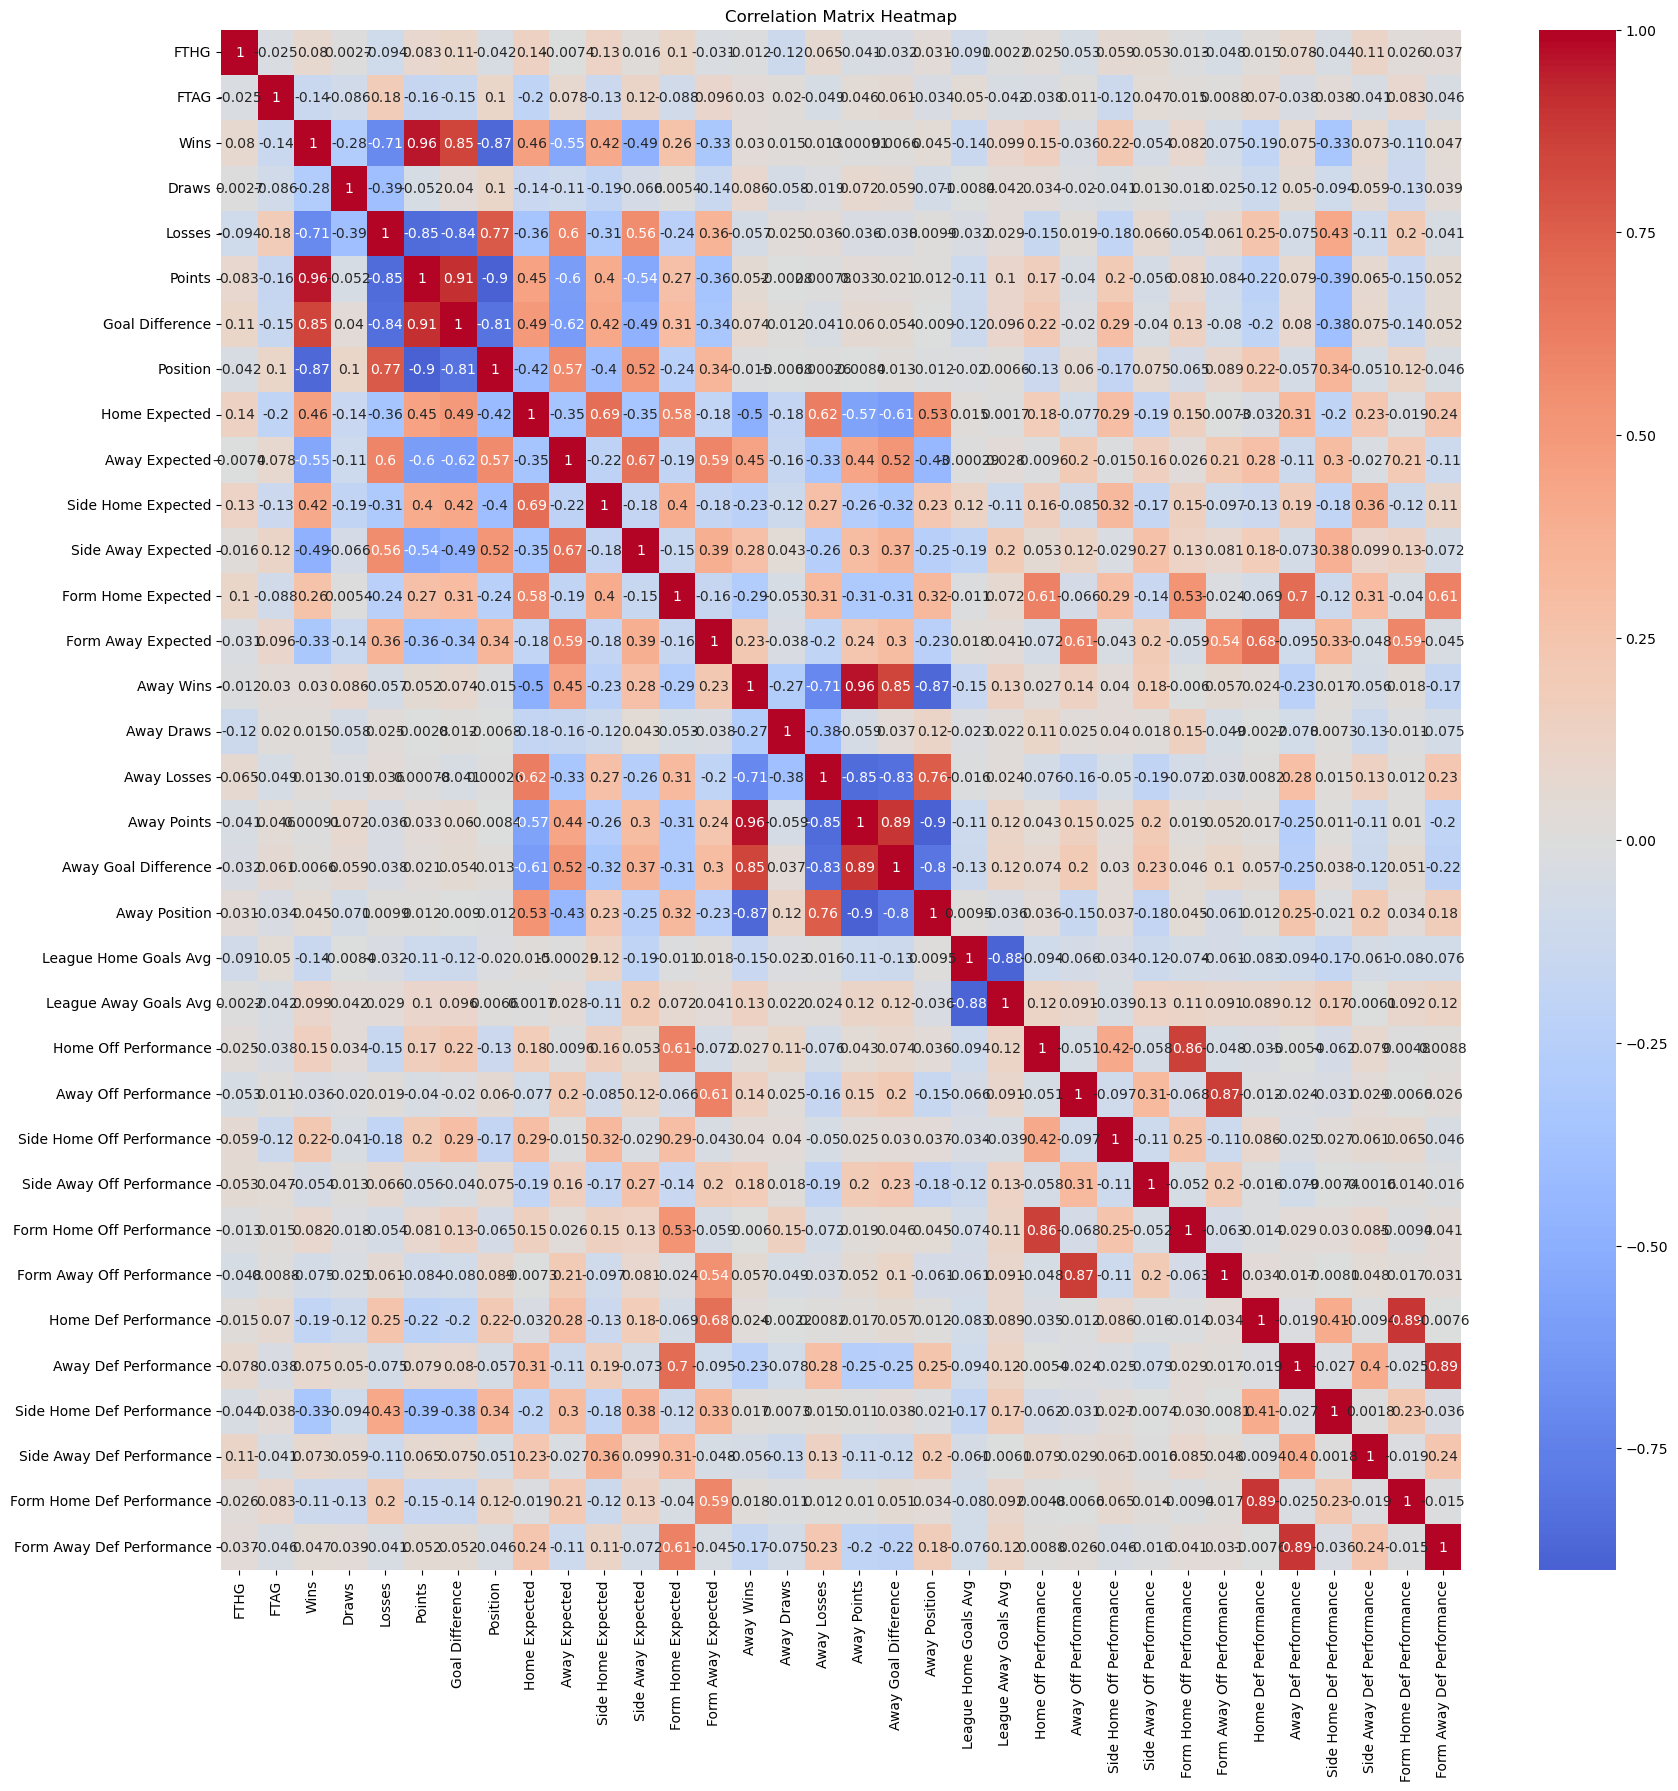

In [18]:
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()